In [36]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data_prep import load_sessions, flatten_events, build_session_features

读取数据。由于数据量巨大，所以只读取前50000条数据

In [37]:
sessions = load_sessions("../data/otto-recsys-train.jsonl", n=50000)
event_df = flatten_events(sessions)
session_features = build_session_features(event_df)

print(len(sessions))
print(event_df.shape)
print(session_features.shape)

50000
(2621110, 4)
(50000, 5)


In [38]:
import json
import pandas as pd

In [39]:
print("事件总数：", len(event_df))
event_df.head()

事件总数： 2621110


,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks


50000个session中共有2621110条event。

In [40]:
event_df['type'].value_counts()#event情况分布

type
clicks    2395745
carts      180595
orders      44770
Name: count, dtype: int64

In [41]:
session_stats = event_df.groupby('session')['type'].count()

print("平均每个 session 行为数:", session_stats.mean())
print("中位数:", session_stats.median())
print("最大值:", session_stats.max())

平均每个 session 行为数: 52.4222
中位数: 19.0
最大值: 495


In [42]:
session_conversion = event_df.groupby('session')['type'].apply(
    lambda x: 'orders' in x.values
)

conversion_rate = session_conversion.mean()

print("Session 转化率:", conversion_rate)

Session 转化率: 0.22962


下面进行用户特征工程。对每个session的情况进行分析，构建session级数据。

In [43]:
session_features = event_df.groupby('session').agg(
    total_events = ('type', 'count'),
    click_cnt = ('type', lambda x: (x == 'clicks').sum()),
    cart_cnt = ('type', lambda x: (x == 'carts').sum()),
    order_cnt = ('type', lambda x: (x == 'orders').sum())
)

session_features['converted'] = session_features['order_cnt'] > 0

session_features.head()

,total_events,click_cnt,cart_cnt,order_cnt,converted
session,,,,,
0,276,255,17,4,True
1,32,24,8,0,False
2,33,32,1,0,False
3,226,200,21,5,True
4,19,15,3,1,True


比较转化用户和未转化用户。

In [44]:
session_features.groupby('converted').mean()


,total_events,click_cnt,cart_cnt,order_cnt
converted,,,,
False,31.791713,30.346245,1.445468,0.000000
True,121.637924,106.858113,10.880324,3.899486


寻找高价值用户。

In [45]:
median_events = session_features['total_events'].median()

high_value = session_features[
    (session_features['total_events'] > median_events) &
    (session_features['converted'] == True)
]

len(high_value)

10282

转化用户VS未转化用户行为差异。

In [46]:
conversion_summary = session_features.groupby('converted').agg(
    avg_click=('click_cnt', 'mean'),
    avg_cart=('cart_cnt', 'mean'),
    avg_events=('total_events', 'mean')
)

conversion_summary

,avg_click,avg_cart,avg_events
converted,,,
False,30.346245,1.445468,31.791713
True,106.858113,10.880324,121.637924


很明显转化用户平均点击率，平均购买意愿，平均购买行为都明显高于未转化用户。接下来计算加购行为占比。

In [47]:
conversion_summary['cart_ratio'] = (
    conversion_summary['avg_cart'] /
    conversion_summary['avg_events']
)

conversion_summary

,avg_click,avg_cart,avg_events,cart_ratio
converted,,,,
False,30.346245,1.445468,31.791713,0.045467
True,106.858113,10.880324,121.637924,0.089448


转化用户cart_ratio明显更高，说明行为结构比行为数量要更为重要。

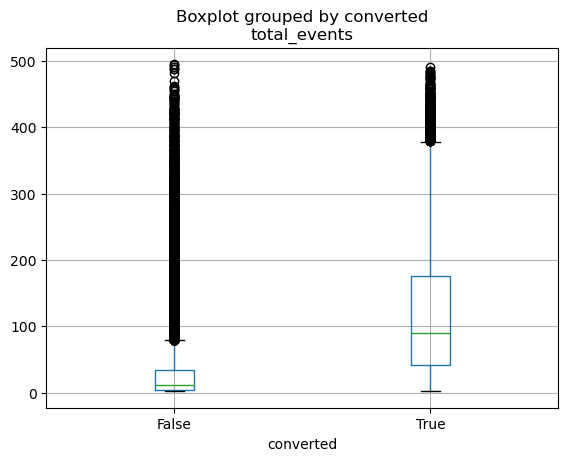

In [48]:
import matplotlib.pyplot as plt

session_features.boxplot(column='total_events', by='converted')
plt.show()

寻找超高价值用户。

In [49]:
threshold = session_features['total_events'].quantile(0.75)

super_users = session_features[
    (session_features['total_events'] > threshold) &
    (session_features['converted'] == True)
]

len(super_users)

7196